<a href="https://colab.research.google.com/github/dondreojordan/DS-Unit-2-Kaggle-Challenge/blob/master/module2-random-forests/LS_DS_222_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

#**NEED TO FIX ERRORS IN NOTES!!!**

# Random Forests

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](http://archive.is/Nu3EI), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [ ] Continue to participate in our Kaggle challenge.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.
- [ ] Try Ordinal Encoding.
- [ ] Try a Random Forest Classifier.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/category_encoders/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

#Import Classifiers

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Engineer DataFrames Train, Test, and Validate

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#Merge Train Features and Train Labels
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

#Read test_features and sample_submission
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

#Split train into train and validation
train, val = train_test_split(train, train_size=.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

print("Check Train Shape: ",train.shape, "\nCheck Test Shape", test.shape)

Check Train Shape:  (47520, 41) 
Check Test Shape (14358, 40)


#Define a function...

    Wrangle(X) train, validate, and test sets.
    Clean outliers.
    Engineer features.

In [ ]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)




print("Check Train Shape: ",train.shape, "\nCheck Validation Shape", val.shape,"\nCheck Test Shape", test.shape)

Check Train Shape:  (47520, 46) 
Check Validation Shape (11880, 46) 
Check Test Shape (14358, 45)


In [ ]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [ ]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

#  We can use Pandas Profiling to get a report,

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

#Categorical Exploration
Re-run until "Ordinal Coding". Change feature to explore.

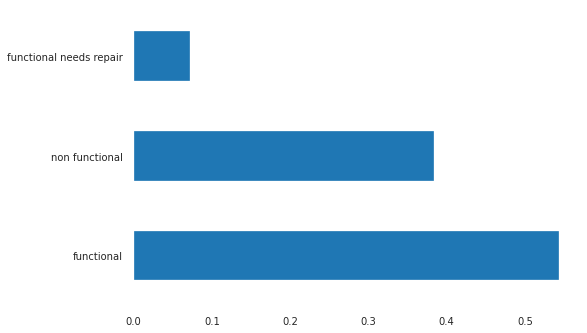

In [ ]:
train['status_group'].value_counts(normalize=True).plot(kind='barh')

In [ ]:
train.describe(exclude='number').columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'longitude_MISSING', 'latitude_MISSING',
       'construction_year_MISSING', 'gps_height_MISSING', 'population_MISSING',
       'years_MISSING'],
      dtype='object')

In [ ]:
#Pull no_num feature from above
feature = 'water_quality'

In [ ]:
X_train[feature].value_counts()

soft                  40598
salty                  3903
unknown                1503
milky                   658
coloured                403
salty abandoned         276
fluoride                165
fluoride abandoned       14
Name: water_quality, dtype: int64

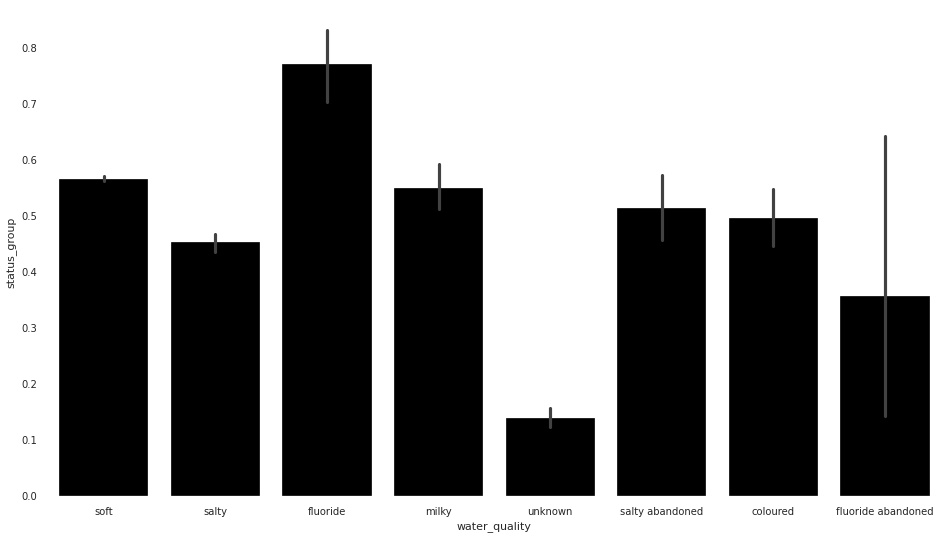

In [ ]:
import matplotlib.pyplot as plt


import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=train[feature], 
    y=train['status_group']=='functional', 
    color='black'
);

#OneHotEncoding (OHE)

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train[[feature]])
print(f'{len(encoded.columns)} columns')
encoded.head(10)

8 columns


,water_quality_soft,water_quality_salty,water_quality_fluoride,water_quality_milky,water_quality_unknown,water_quality_salty abandoned,water_quality_coloured,water_quality_fluoride abandoned
43360,1,0,0,0,0,0,0,0
7263,1,0,0,0,0,0,0,0
2486,0,1,0,0,0,0,0,0
313,1,0,0,0,0,0,0,0
52726,1,0,0,0,0,0,0,0
8558,1,0,0,0,0,0,0,0
2559,1,0,0,0,0,0,0,0
54735,1,0,0,0,0,0,0,0
25763,1,0,0,0,0,0,0,0
44540,1,0,0,0,0,0,0,0


In [ ]:
oic_model = Pipeline([
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('classifier', DecisionTreeClassifier())
                  ])

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

lr = Pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(),
    LogisticRegressionCV(random_state=0, solver='lbfgs')
)

lr.fit(X_train[[feature]], y_train)
score = lr.score(X_val[[feature]], y_val)
print('Logistic Regression, Validation Accuracy', score)

TypeError: ignored

###One-Hot Encoding, Decision Tree, Validation Accuracy

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = Pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train[[feature]], y_train)
score = dt.score(X_val[[feature]], y_val)
print('Decision Tree, Validation Accuracy', score)

TypeError: ignored

###One-Hot Encoding, Logistic Regression, Model Interpretation

In [ ]:
model = lr.named_steps['logisticregressioncv']
encoder = lr.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
coefficients.sort_values().plot.barh(color='grey');

NameError: ignored

#### One-Hot Encoding, Decision Tree, Model Interpretation

In [ ]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=7, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

#Ordinal Coding

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder

In [ ]:
encoder = ce.OrdinalEncoder()
encoded = encoder.fit_transform(X_train[[feature]])
print(f'1 column, {encoded[feature].nunique()} unique values')
encoded.head(20)

###Ordinal Encoding, Logistic Regression, Validation Accuracy

In [ ]:
lr = pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=-1)
)

lr.fit(X_train[[feature]], y_train)
score = lr.score(X_val[[feature]], y_val)
print('Logistic Regression, Validation Accuracy', score)

###Ordinal Encoding, Decision Tree, Validation Accuracy

In [ ]:
dt = pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train[[feature]], y_train)
score = dt.score(X_val[[feature]], y_val)
print('Decision Tree, Validation Accuracy', score)

###Ordinal Encoding, Logistic Regression, Model Interpretation

In [ ]:
model = lr.named_steps['logisticregressioncv']
encoder = lr.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
coefficients.sort_values().plot.barh(color='grey');

###Ordinal Encoding, Decision Tree, Model Interpretation

In [ ]:
model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=5, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

#     Understand how tree ensembles (multiple decision trees) reduce overfitting compared to a single decision tree with unlimited depth

In [ ]:
import itertools
import seaborn as sns

def pred_heatmap(model, X, features, class_index=-1, title='', num=100):
    """
    Visualize predicted probabilities, for classifier fit on 2 numeric features
    
    Parameters
    ----------
    model : scikit-learn classifier, already fit
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 numeric features
    class_index : integer, index of class label
    title : string, title of plot
    num : int, number of grid points for each feature
    
    Returns
    -------
    y_pred_proba : numpy array, predicted probabilities for class_index
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(max2, min2, num)
    combos = list(itertools.product(x1, x2))
    y_pred_proba = model.predict_proba(combos)[:, class_index]
    pred_grid = y_pred_proba.reshape(num, num).T
    table = pd.DataFrame(pred_grid, columns=x1, index=x2)
    sns.heatmap(table, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.show()
    return y_pred_proba

###Compare Decision Tree, Random Forest, Logistic Regression

In [ ]:
train.describe(exclude='number').columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'longitude_MISSING', 'latitude_MISSING',
       'construction_year_MISSING', 'gps_height_MISSING', 'population_MISSING',
       'years_MISSING'],
      dtype='object')

In [ ]:
# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders
feature1 = 'years_MISSING'
feature2 = 'population_MISSING'

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def get_X_y(df, feature1, feature2, target):
    features = [feature1, feature2]
    X = df[features]
    y = df[target]
    X = X.fillna(X.median())
    X = ce.OrdinalEncoder().fit_transform(X)
    return X, y

def compare_models(max_depth=1, n_estimators=1):
    models = [DecisionTreeClassifier(max_depth=max_depth), 
              RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators), 
              LogisticRegression(solver='lbfgs', multi_class='auto')]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(X, y)
        pred_heatmap(model, X, [feature1, feature2], class_index=0, title=name)

X, y = get_X_y(train, feature1, feature2, target='status_group')
interact(compare_models, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

###Bagging

In [ ]:
# Do-it-yourself Bagging Ensemble of Decision Trees (like a Random Forest)

# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders
import category_encoders as ce
feature1 = 'years_MISSING'
feature2 = 'population_MISSING'

def waterpumps_bagging(max_depth=1, n_estimators=1):
    predicteds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = train.sample(n=len(train), replace=True)
        X, y = get_X_y(bootstrap_sample, feature1, feature2, target='status_group')
        tree = DecisionTreeClassifier(max_depth=max_depth)
        tree.fit(X, y)
        predicted = pred_heatmap(tree, X, [feature1, feature2], class_index=0, title=title)
        predicteds.append(predicted)
    
    ensembled = np.vstack(predicteds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    sns.heatmap(ensembled.reshape(100, 100).T, vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.show()
        
interact(waterpumps_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=2, descriptio…

In [43]:
#Random Forest Classification w/ Validation Accuracy Score
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=0, n_jobs=1)
)
#   F I T
pipeline.fit(X_train, y_train)
print("Training Accuracy", pipeline.score(X_train, y_train))
print("Validation Accuracy", pipeline.score(X_val, y_val))

Training Accuracy 0.9979166666666667
Validation Accuracy 0.8088383838383838
CPU times: user 22.7 s, sys: 213 ms, total: 22.9 s
Wall time: 22.9 s


In [ ]:
"""Lookeyyyyy Here"""

'Lookeyyyyy Here'

In [44]:
oic_model = Pipeline([
                  #('ord',OrdinalEncoder()),
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('classifier', RandomForestClassifier())
                  ])

In [52]:
%%time
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=199, min_samples_split=8)
)
#   F I T
pipeline.fit(X_train, y_train)
print("Training Accuracy", pipeline.score(X_val, y_val))
print("Validation Accuracy", pipeline.score(X_val, y_val))

Training Accuracy 0.8148148148148148
Validation Accuracy 0.8148148148148148
CPU times: user 42.6 s, sys: 255 ms, total: 42.8 s
Wall time: 24.7 s


#Dondre' After Hours Study Session DS 211 Notes¶
Instructor: Keri Kalmbuch


### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_


### More Categorical Encodings

**1.** The article **[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)** mentions 4 encodings:

- **"Categorical Encoding":** This means using the raw categorical values as-is, not encoded. Scikit-learn doesn't support this, but some tree algorithm implementations do. For example, [Catboost](https://catboost.ai/), or R's [rpart](https://cran.r-project.org/web/packages/rpart/index.html) package.
- **Numeric Encoding:** Synonymous with Label Encoding, or "Ordinal" Encoding with random order. We can use [category_encoders.OrdinalEncoder](https://contrib.scikit-learn.org/category_encoders/ordinal.html).
- **One-Hot Encoding:** We can use [category_encoders.OneHotEncoder](https://contrib.scikit-learn.org/category_encoders/onehot.html).
- **Binary Encoding:** We can use [category_encoders.BinaryEncoder](https://contrib.scikit-learn.org/category_encoders/binary.html).


**2.** The short video 
**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)** introduces an interesting idea: use both X _and_ y to encode categoricals.

Category Encoders has multiple implementations of this general concept:

- [CatBoost Encoder](https://contrib.scikit-learn.org/category_encoders/catboost.html)
- [Generalized Linear Mixed Model Encoder](https://contrib.scikit-learn.org/category_encoders/glmm.html)
- [James-Stein Encoder](https://contrib.scikit-learn.org/category_encoders/jamesstein.html)
- [Leave One Out](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html)
- [M-estimate](https://contrib.scikit-learn.org/category_encoders/mestimate.html)
- [Target Encoder](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
- [Weight of Evidence](https://contrib.scikit-learn.org/category_encoders/woe.html)

Category Encoder's mean encoding implementations work for regression problems or binary classification problems. 

For multi-class classification problems, you will need to temporarily reformulate it as binary classification. For example:

```python
encoder = ce.TargetEncoder(min_samples_leaf=..., smoothing=...) # Both parameters > 1 to avoid overfitting
X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')
X_val_encoded = encoder.transform(X_train, y_val=='functional')
```

For this reason, mean encoding won't work well within pipelines for multi-class classification problems.

**3.** The **[dirty_cat](https://dirty-cat.github.io/stable/)** library has a Target Encoder implementation that works with multi-class classification.

```python
 dirty_cat.TargetEncoder(clf_type='multiclass-clf')
```
It also implements an interesting idea called ["Similarity Encoder" for dirty categories](https://www.slideshare.net/GaelVaroquaux/machine-learning-on-non-curated-data-154905090).

However, it seems like dirty_cat doesn't handle missing values or unknown categories as well as category_encoders does. And you may need to use it with one column at a time, instead of with your whole dataframe.

**4. [Embeddings](https://www.kaggle.com/colinmorris/embedding-layers)** can work well with sparse / high cardinality categoricals.

_**I hope it’s not too frustrating or confusing that there’s not one “canonical” way to encode categoricals. It’s an active area of research and experimentation — maybe you can make your own contributions!**_

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [ ]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [ ]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

#Use SciKit-Learn Random Forests

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [ ]:
oic_model = Pipeline([
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('classifier', DecisionTreeClassifier())
                  ])

In [ ]:
%%time 
# How hard are we working our machine
oic_model.fit(X_train, y_train)

print('training accuracy:', oic_model.score(X_train, y_train))
print('validation accuracy:', oic_model.score(X_val, y_val))

training accuracy: 0.9979377104377104
validation accuracy: 0.7584175084175084
CPU times: user 7.3 s, sys: 193 ms, total: 7.5 s
Wall time: 7.51 s


In [ ]:
print("This is how many cuts the Decision Tree did:", oic_model.named_steps['classifier'].get_depth())


This is how many cuts the Decision Tree did: 46


In [ ]:
%%time
oisc_model = Pipeline([
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('select', SelectKBest(k=20)),
                  ('classifier', DecisionTreeClassifier())
                  ])

oisc_model.fit(X_train, y_train)

print('training accuracy:', oisc_model.score(X_train, y_train))
print('validation accuracy:', oisc_model.score(X_val, y_val))

training accuracy: 0.7683080808080808
validation accuracy: 0.7401515151515151
CPU times: user 5.96 s, sys: 119 ms, total: 6.08 s
Wall time: 6.08 s


In [ ]:
print("This is how many cuts the Decision Tree did:", oisc_model.named_steps['classifier'].get_depth())

This is how many cuts the Decision Tree did: 27


In [ ]:
print("Against:", oic_model.named_steps['classifier'].get_depth())

Against: 46


In [ ]:
ohe = oic_model.named_steps['ohe']
X_trans = ohe.transform(X_train)
print("X Train Shape:", X_train.shape)
print("X Transformed Shape:", X_trans.shape)

X Train Shape: (47520, 38)
X Transformed Shape: (47520, 182)


In [ ]:
%%time
model = Pipeline([
                  ('ohe', OrdinalEncoder()),
                  ('impute', SimpleImputer()),
                  ('classifier', DecisionTreeClassifier())
])

model.fit(X_train, y_train)

print('training accuracy:', model.score(X_train, y_train))
print('validation accuracy:', model.score(X_val, y_val))

training accuracy: 0.9979377104377104
validation accuracy: 0.7511784511784512
CPU times: user 1.85 s, sys: 34.4 ms, total: 1.89 s
Wall time: 1.89 s


In [ ]:
%%time
model = Pipeline([
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('classifier', RandomForestClassifier())
])
#This FITTING is important in the pipeline
model.fit(X_train, y_train)


print('training accuracy:', model.score(X_train, y_train))
print('validation accuracy:', model.score(X_val, y_val))

#Time went up to train a lot more trees. 
#We aren't overfit  becuase of the overfitting across the entire forest balances everything out. 

training accuracy: 0.997895622895623
validation accuracy: 0.8090909090909091
CPU times: user 21.8 s, sys: 329 ms, total: 22.2 s
Wall time: 22.2 s


**What is the difference between the two used for categorical encoding?**
###One Hot Encoder (OHE)


###Ordinal Encoder
    What is an example of ordinal numbers?
The numbers 1st(First), 2nd(Second), 3rd(Third), 4th(Fourth), 5th(Fifth), 6th(Sixth), 7th(Seventh), 8th(Eighth), 9th(Ninth) and 10th(Tenth) tell the position of different athletes in the race. Hence, all of them are ordinal numbers.




```
Understand how categorical encodings affect trees differently compared to linear models
```



### Categorical exploration, 1 feature at a time

Change `feature`, then re-run these cells!